In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import networkx as nx

from network import Network
from data import get_MNIST_data_loaders
from train import train_network
from evaluate import accuracy
from utils import reshape_image

from community import community_louvain

In [2]:
def load_network(fname):
    state = torch.load(fname)
    model = Network(
        1 if state["variant"] == "p" else 28, 
        state["hidden_dim"], 
        10,
        freeze_neurons=state["freeze_neurons"], 
        freeze_g=state["freeze_activations"]
    )
    model.load_state_dict(state["model_state_dict"])
    return model

In [3]:
variant = "l"
train_loader, test_loader = get_MNIST_data_loaders(256, variant=variant)

In [4]:
model = load_network("model/network_params/l_256_False_True.pt")

{'model_state_dict': OrderedDict([('fc1.weight', tensor([[ 2.1422, -2.0112,  0.8779,  ...,  2.5979,  4.0831,  0.4008],
        [-0.8041, -4.0736,  3.7320,  ..., -5.4056,  2.7906,  3.3429],
        [ 3.5843, -2.6759,  1.2566,  ...,  0.4305, 20.8067,  1.8298],
        ...,
        [-6.2800, -1.0461, -3.4604,  ...,  1.6933,  5.3178,  1.8296],
        [ 4.7534,  7.1480,  4.5995,  ..., -0.5239,  2.0542,  5.0572],
        [ 1.1244,  4.9755,  1.4325,  ..., -0.3622, -5.3932,  1.1594]])), ('fc1.bias', tensor([ 0.3079,  0.3388,  2.3776, -0.8150,  0.2880,  0.0621,  1.2237, -0.8757,
         1.0120, -0.7354, -0.0527,  0.1376,  1.4585, -1.2126,  0.2148,  0.1051,
         0.5638,  0.1054, -0.1465, -0.2726, -0.0522,  0.0374,  1.2071,  0.1614,
        -0.1137,  0.7666,  2.5284, -0.9862, -0.1938, -0.0221, -0.6652,  0.3811,
         0.7170, -0.3605,  0.0304,  0.1687, -0.9583,  0.3845,  0.0650,  0.2226,
         0.3747, -0.7837, -0.5688,  0.5771, -0.8441, -0.4764,  0.2637,  0.0618,
         0.2794, -0.17

In [5]:
model.hidden_neurons.ds

Parameter containing:
tensor([1.0000, 0.6321, 0.3297, 0.1813, 0.0952, 0.0392, 0.0198, 0.0100])

In [14]:
with torch.no_grad():
    fs = []
    for x, label in test_loader:
        x = reshape_image(x, variant=variant)
        
        # sequentially send input into network
        model.reset(x.shape[0])
        for i in range(x.shape[1]):
            model(x[:, i, :])
            fs.append(model.hidden_neurons.fs)

        total_pred = torch.zeros(x.shape[0], 10)
        for _ in range(5):
            pred_y = model(model.zero_input(x.shape[0]))
            fs.append(model.hidden_neurons.fs)
        break

0


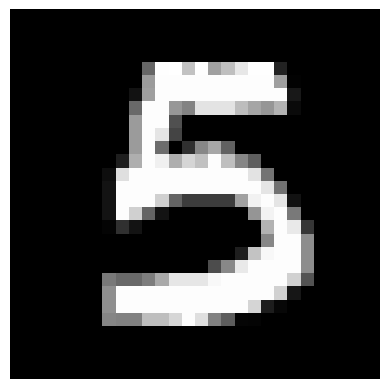

1


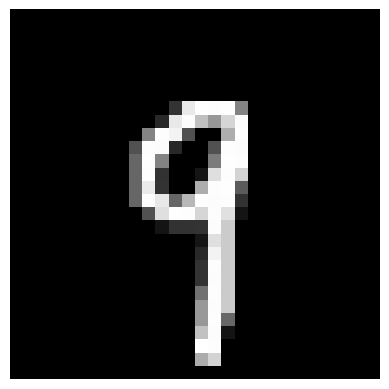

2


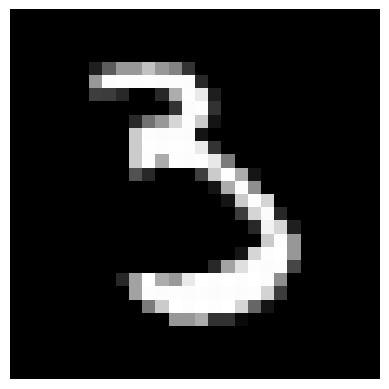

3


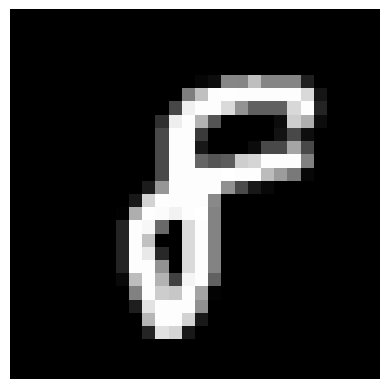

4


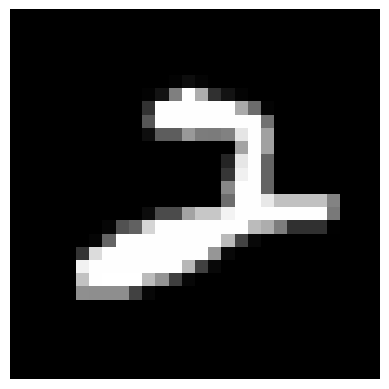

5


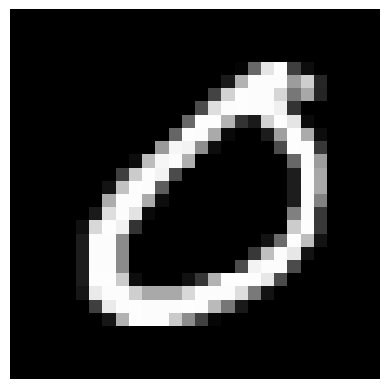

6


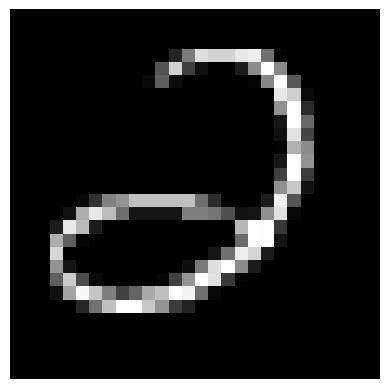

7


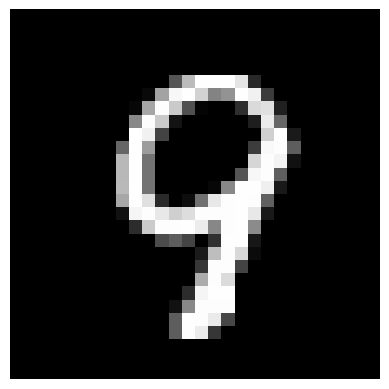

8


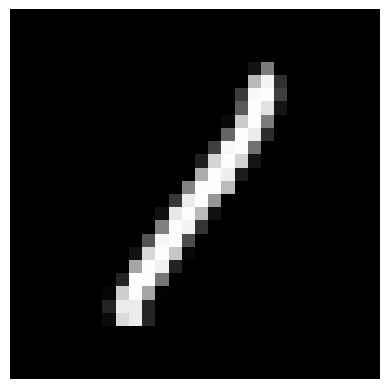

9


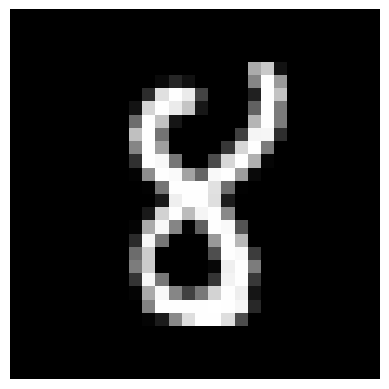

10


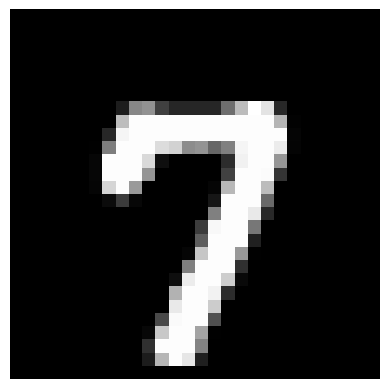

11


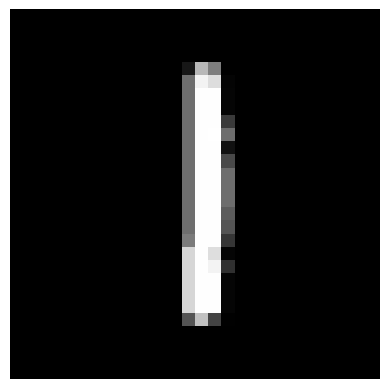

12


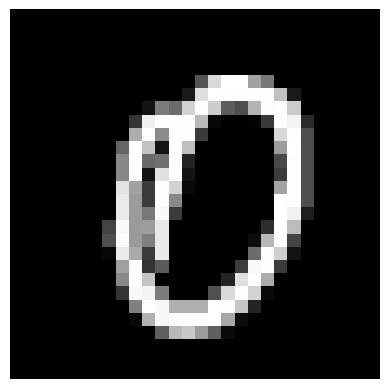

13


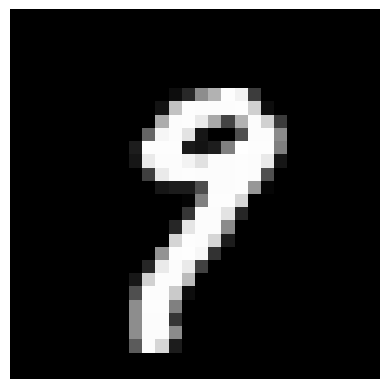

14


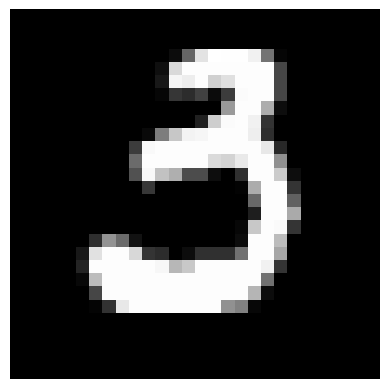

15


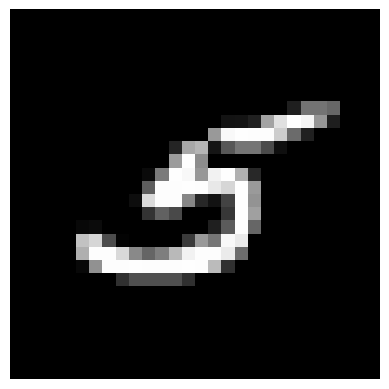

16


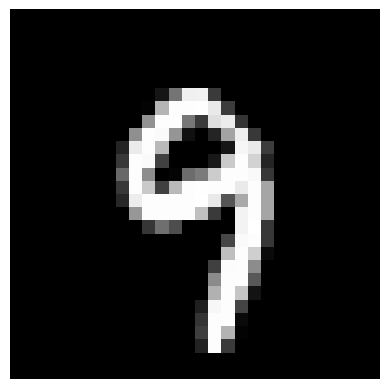

17


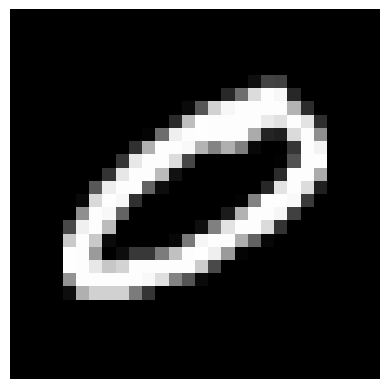

18


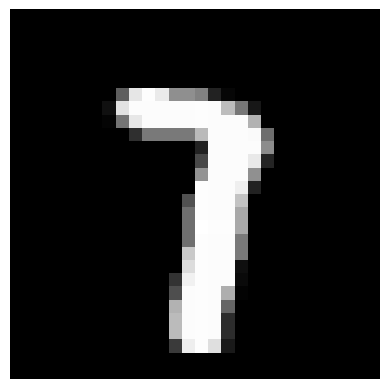

19


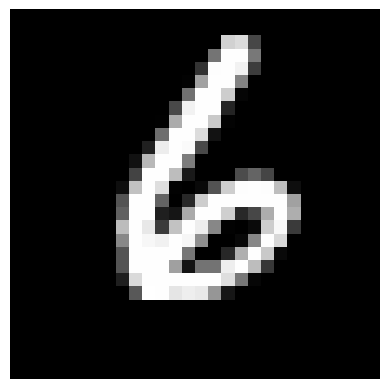

In [15]:
for i in range(20):
    print(i)
    plt.figure()
    plt.imshow(x.detach()[i, :, :], cmap="gray")
    plt.axis("off")
    plt.show()

In [16]:
i = 0

In [17]:
As = torch.stack([f[i,:] for f in fs])
with torch.no_grad():
    w = F.softmax(model.fc3(fs[-1][i,:]), dim=0)

(-0.5, 27.5, 27.5, -0.5)

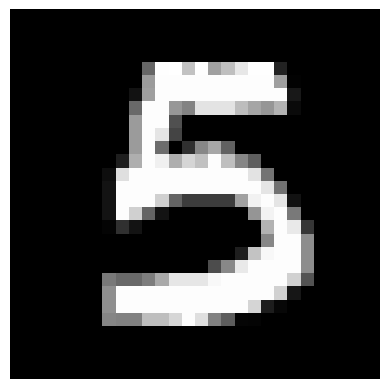

In [18]:
plt.imshow(x.detach()[i, :, :], cmap="gray")
plt.axis("off")

/var/folders/_r/m9hbjyhd13bbv3lg031lk0fc0000gn/T/ipykernel_14353/784502518.py:2: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout(pad=1.0)


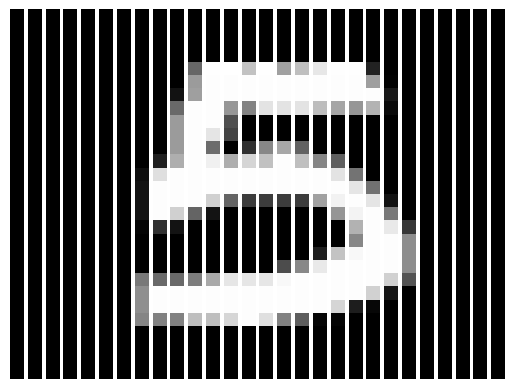

In [19]:
fig, axs = plt.subplots(1, 28)
fig.tight_layout(pad=1.0)
for j in range(28):
    axs[j].imshow(x.detach()[i, :, j].reshape(28, 1), cmap="gray", vmin=0, vmax=1)
    axs[j].axis("off")

In [20]:
x.shape

torch.Size([256, 28, 28])

/var/folders/_r/m9hbjyhd13bbv3lg031lk0fc0000gn/T/ipykernel_14353/3399382440.py:2: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout(pad=1.0)


RuntimeError: shape '[24, 24]' is invalid for input of size 784

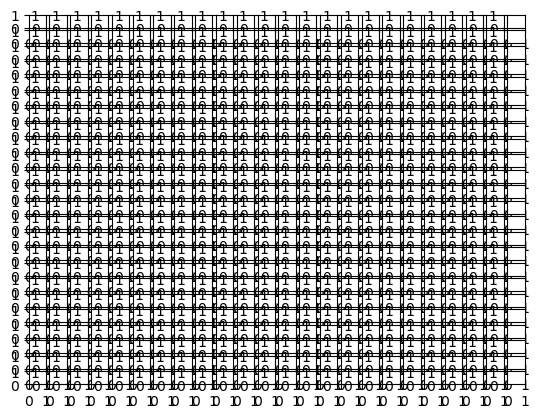

In [21]:
fig, axs = plt.subplots(24, 24)
fig.tight_layout(pad=1.0)
for j in range(24):
    for k in range(24):
        axs[j, k].imshow(x.detach()[i, :, :].reshape(24, 24)[j, k].reshape(1, 1), cmap="gray", vmin=0, vmax=1)
        axs[j, k].axis("off")

In [22]:
A = model.fc2.weight.detach().abs().numpy()
G = nx.from_numpy_array(A)
partition = community_louvain.best_partition(G)

order = []
for v in np.unique(list(partition.values())):
    for k in partition:
        if partition[k] == v:
            order.append(k)

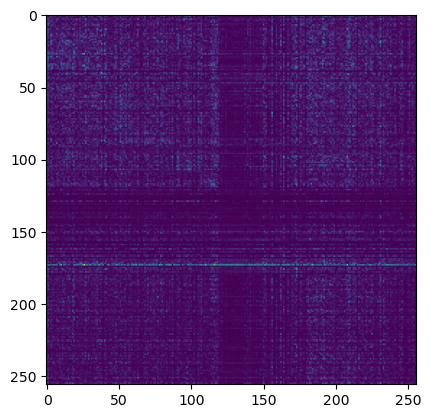

In [23]:
plt.imshow(A[order, :][:, order])

Text(0, 0.5, 'neuron')

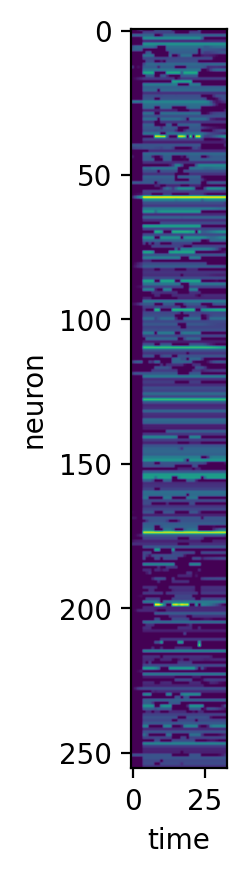

In [24]:
plt.figure(dpi=200)
plt.imshow(As.T[order, :])
#plt.imshow(As.T)
plt.xlabel("time")
plt.ylabel("neuron")

In [ ]:
plt.figure(dpi=200)
plt.imshow(w.reshape(-1, 1))
#plt.yticks(ticks=np.arange(0, 10), minor=True)
plt.yticks(np.arange(10), [str(i) for i in range(10)])
plt.xticks([]);